In this project, we first created a classification model to predict whether stock data would go up or down for one day. Then, we created a LSTM model that would allow us to predict what the stock price would be for an “user-selected” arbitrary number of days. We tended to train our data around predicting for 1 month in advance. In general, we primarily trained exclusively on historical equity price data. One of the issues that primarily came up when attempting to add features was the accessibility of financial information. Many of the data sources only contained historical equity price data for free. To access any other information, such as P/E ratios, EPS ratios, etc..., you needed to pay for premium subscriptions. As a result, we were unable to access relevant financial information for the time period we were using in order to add the features that we wanted.
_______________________________________________________________________________________________________________________________

This is the comparison model we built in order as way to benchmark our LSTM model. The essence of this model is to predict the closing price for one day in advance (either up or down) based on historical data.


In [67]:
import pandas as pd
import numpy as np
import datetime
import sys
import quandl
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None 

We started by pulling stock data using the duandl library. Each dataframe initially contained the open/close/high/low price of the stock for each day from 1983-2018. Our goal was to predict whether the stock price would increase or decrease the following day based on previous data. We used five different models to see which ones would perform better on different data sets, with the three we went over in class as well as the Random Forest Classifier and the SVC, which we found to do better on the benchmark data.

In [68]:
def f(s):
    a = [str(x) for x in s]
    a[1] = str(1)
    return "/".join(a)
def add_features(s):
    arr = [c for c in s]
#     add_nasdaq(arr)
    return np.array(arr)
def calcS(df):
    temp = df.shift(1) - df
    temp['delt'] = temp['Close'].apply(sign)
    return temp
def add_features(s):
    arr = [c for c in s]
#     add_nasdaq(arr)
    return np.array(arr)
def sign(x):
    if x > 0:
        return -1
    else:
        return 1

We then calculated the change in price by shifting the dataframe and subtracting it from itself. We took the sign of this value which became the label for each day. We took a benchmark of the classifiers without adding in extra features and saw a pretty low accuracy of 48.1% for naive bayes, but up to 52% for SVC and Random Forest Classifier.

In [69]:
model1 = GaussianNB()
model2 = KNeighborsClassifier()
model3 = BernoulliNB()
model4 = RandomForestClassifier()
model5 = SVC()
dfA = quandl.get("WIKI/AMD")
dfA.tail()
dfI = quandl.get("WIKI/INTC")
dfI.tail()
dfN = quandl.get("WIKI/NVDA")
dfN.tail(10)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-14,249.45,250.55,246.220,248.74,12573947.0,0.0,1.0,249.45,250.55,246.220,248.74,12573947.0
2018-03-15,249.29,252.62,247.640,249.34,9992834.0,0.0,1.0,249.29,252.62,247.640,249.34,9992834.0
2018-03-16,250.00,251.25,248.480,250.48,9634107.0,0.0,1.0,250.00,251.25,248.480,250.48,9634107.0
2018-03-19,248.18,249.35,237.000,241.00,17472128.0,0.0,1.0,248.18,249.35,237.000,241.00,17472128.0
2018-03-20,241.12,251.15,241.120,249.58,13725505.0,0.0,1.0,241.12,251.15,241.120,249.58,13725505.0
2018-03-21,249.32,252.00,247.330,248.56,10841782.0,0.0,1.0,249.32,252.00,247.330,248.56,10841782.0
2018-03-22,246.00,247.88,240.341,241.85,13663927.0,0.0,1.0,246.00,247.88,240.341,241.85,13663927.0
2018-03-23,242.40,242.67,232.520,232.97,18225390.0,0.0,1.0,242.40,242.67,232.520,232.97,18225390.0
2018-03-26,238.00,244.53,235.900,244.48,15130542.0,0.0,1.0,238.00,244.53,235.900,244.48,15130542.0


We then looked at features we could add and decided on several that would provide information about global markets as well as historical data on AMD. The first feature was data on the NASDAQ index, which helps define performance of the entire US economy as a whole. We also incorporated google trends data, as a larger trend value could mean larger variance in stock price the following day. Finally, we incorporated company specific data, in calculating the moving-average of 5 and 10 days, essentially the average closing price over the period of time, because crossing the moving average or pulling away from it can define the start of a bull or bear trend. We then added features based on financial ratios found on the balance sheet such as beta, the volatility of the stock, as well as price/earnings ratio, a figure that compares the stock price to how much investers make from the stock on average.

In [70]:
quandl.ApiConfig.api_key = 'bjxPxJDJRbGxYNqxstKH'
cols = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
ncols = ["Tdate", "IndexV", "H", "L", "TargetMarket", "DMV"]
dfAR = pd.read_csv('AMD.csv', sep=',', names=cols,
                    encoding='latin-1')
dfn = pd.read_csv('NASDAQ.csv', sep=',', names=ncols,
                    encoding='latin-1')
dfn = dfn[1:]
dfn = dfn[::-1]
dfAR = dfAR[3:]
dfn.head()
dfNratio = pd.read_csv('out.csv', sep=',', header = 0, index_col=0,
                    encoding='latin-1')
dftrends = pd.read_csv('trends.csv', sep=',', header = 0, index_col=0,
                    encoding='latin-1')
dfAmd = pd.read_csv('Amd_historical.csv', sep=',', header = 0, index_col=0,
                    encoding='latin-1')
dfNratio.head()
dftrends.head()
dfAmd.head()

,Open,High,Low,Close,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,5-day Moving,10-day Moving
Date,,,,,,,,,,,,
3/21/83,35.88,36.13,35.25,36.00,127700.0,8.97,9.03,8.81,9.00,510800.0,35.0,34.56
3/22/83,34.88,35.88,34.00,34.00,82000.0,8.72,8.97,8.50,8.50,328000.0,35.0,34.56
3/23/83,34.00,35.25,33.88,34.88,106800.0,8.50,8.81,8.47,8.72,427200.0,35.0,34.56
3/24/83,34.88,35.13,34.63,35.13,98300.0,8.72,8.78,8.66,8.78,393200.0,35.0,34.56
3/25/83,35.63,36.25,35.00,35.50,52600.0,8.91,9.06,8.75,8.87,210400.0,35.1,34.56


In [71]:
dftrends['d2'] = dftrends.index
dftrends['d2'] = dftrends['d2'].apply(lambda x: str(x)[:7])
# dftrends.head()
dfAc = dfAmd[-1727:]
dfAc['d2'] = dfAc.index
dfAc['d2'] = dfAc['d2'].apply(lambda x: f(str(x).split('/')))
# dfAc.head()
s1 = pd.merge(dfAc, dftrends, how='left', on=['d2'])
s1 = s1.drop(columns=['d2', 'isPartial'])
# s1.head()
dfAc = dfAc.drop(columns=['d2'])
# dfAc.head()
dfAcs = calcS(dfAc)
# dfAcs.head()
dfAcs.shape
featureAmd = [add_features(a) for a in np.array(s1)]
for i in range(len(featureAmd)):
    temp = [float(a) for a in featureAmd[i]]
    temp.extend([float(a) for a in dfNratio.iloc[i]])
    featureAmd[i] = np.array(temp)
#split the data
xtrain = featureAmd[:1000]
xlabels = np.array(dfAcs['delt'])[:1000]
ytest = featureAmd[1000:]
ylables = np.array(dfAcs['delt'])[1000:]
x2 = [item for sublist in xtrain for item in sublist]


In [72]:
# Check for null values in training data
for i in range(len(xtrain)):
    for j in range(len(xtrain[i])):
        if not np.isfinite(xtrain[i][j]):
            print(i, j)
            print("here")

In [73]:
model1.fit(xtrain, xlabels)
predicted1 = model1.predict(ytest)
expected1 = ylables

model2.fit(xtrain, xlabels)
predicted2 = model2.predict(ytest)
expected2 = ylables

model3.fit(xtrain, xlabels)
predicted3 = model3.predict(ytest)
expected3 = ylables

model4.fit(xtrain, xlabels)
predicted3 = model3.predict(ytest)
expected3 = ylables

model5.fit(xtrain, xlabels)
predicted3 = model3.predict(ytest)
expected3 = ylables
print("Gaussian NB\n")
print(metrics.accuracy_score(expected1, predicted1))
print(metrics.classification_report(expected1, predicted1))
print(metrics.confusion_matrix(expected1, predicted1))
print("\n")

print("K-Neighbors Classifier\n")
print(metrics.accuracy_score(expected2, predicted2))
print(metrics.classification_report(expected2, predicted2))
print(metrics.confusion_matrix(expected2, predicted2))
print("\n")

print("Bernoulli NB\n")
print(metrics.accuracy_score(expected3, predicted3))
print(metrics.classification_report(expected3, predicted3))
print(metrics.confusion_matrix(expected3, predicted3))
print("\n")

print("Random Forest\n")
print(metrics.accuracy_score(expected3, predicted3))
print(metrics.classification_report(expected3, predicted3))
print(metrics.confusion_matrix(expected3, predicted3))
print("\n")

print("SVC\n")
print(metrics.accuracy_score(expected3, predicted3))
print(metrics.classification_report(expected3, predicted3))
print(metrics.confusion_matrix(expected3, predicted3))
print("\n")

Gaussian NB

0.547455295735901
              precision    recall  f1-score   support

          -1       0.52      0.07      0.13       331
           1       0.55      0.94      0.69       396

   micro avg       0.55      0.55      0.55       727
   macro avg       0.54      0.51      0.41       727
weighted avg       0.54      0.55      0.44       727

[[ 24 307]
 [ 22 374]]


K-Neighbors Classifier

0.48005502063273725
              precision    recall  f1-score   support

          -1       0.43      0.40      0.41       331
           1       0.52      0.54      0.53       396

   micro avg       0.48      0.48      0.48       727
   macro avg       0.47      0.47      0.47       727
weighted avg       0.48      0.48      0.48       727

[[134 197]
 [181 215]]


Bernoulli NB

0.4718019257221458
              precision    recall  f1-score   support

          -1       0.45      0.75      0.56       331
           1       0.53      0.24      0.33       396

   micro avg       0.47 

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [167]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

We start by reading the file. If it is not in the folder, then it will download it off of alphavantage or kaggle. We read the csv file and store it in a dataframe.

In [196]:
api_key = {"key":"da93c11f138d144060af53abb79ad9de"}


data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'da93c11f138d144060af53abb79ad9de'

    # Ticker for stock price
    ticker = "AMD"
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')
df = df[::-1]
df.head()

Data saved to : stock_market_data-AMD.csv


,Date,Low,High,Close,Open
0,1998-01-02,18.19,19.31,19.31,18.25
1,1998-01-05,18.88,19.5,19.31,19.38
2,1998-01-06,19.69,20.88,19.88,20.13
3,1998-01-07,18.75,19.63,19,19.56
4,1998-01-08,18.75,19.69,18.94,19.06


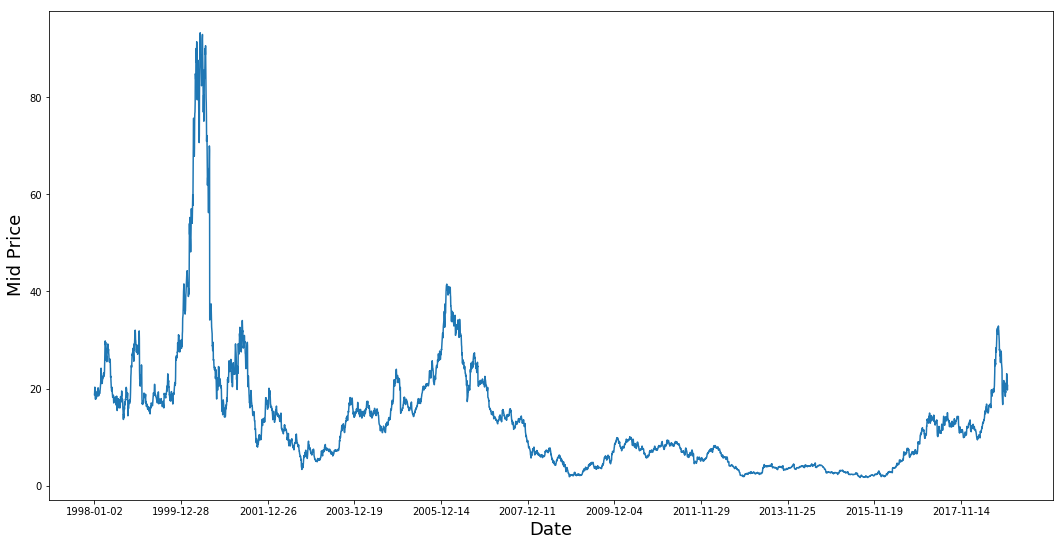

In [197]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Here we average the high and low prices to calculate the mid price for each date. This is then used as our training and test data.

In [198]:
# calcualte mid prices
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0
# Setup array to add features
mid_prices = [[x] for x in mid_prices]

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Here we separate our data into two arrays. This is to allow for our data to train itself by comparing itself to the actual share price.

In [199]:
#  split data into train/tests
mp = len(mid_prices)//2
train_data = mid_prices[:mp]
test_data = mid_prices[mp:]

We smooth all of our data to a range of approximately within the smoothing window to account for large variations in price over time for the data.

In [200]:
scaler = MinMaxScaler()
train_data = np.asarray(train_data).reshape(-1,1)
test_data = np.asarray(test_data).reshape(-1,1)

smoothing_window_size = mp//4
for di in range(0,mp,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])
if (di+smoothing_window_size < len(train_data)):
    scaler.fit(train_data[di+smoothing_window_size:,:])
    train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])
    
for di in range(0,mp,smoothing_window_size):
    scaler.fit(test_data[di:di+smoothing_window_size,:])
    test_data[di:di+smoothing_window_size,:] = scaler.transform(test_data[di:di+smoothing_window_size,:])
if (di+smoothing_window_size < len(train_data)):
    scaler.fit(test_data[di+smoothing_window_size:,:])
    test_data[di+smoothing_window_size:,:] = scaler.transform(test_data[di+smoothing_window_size:,:])


Calculate EMA for next day prediction

In [201]:
EMA = 0.0
gamma = 0.1
for ti in range(mp):
    EMA = gamma*(train_data[ti])[0] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)


In [202]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00875


Plotting next day prediction

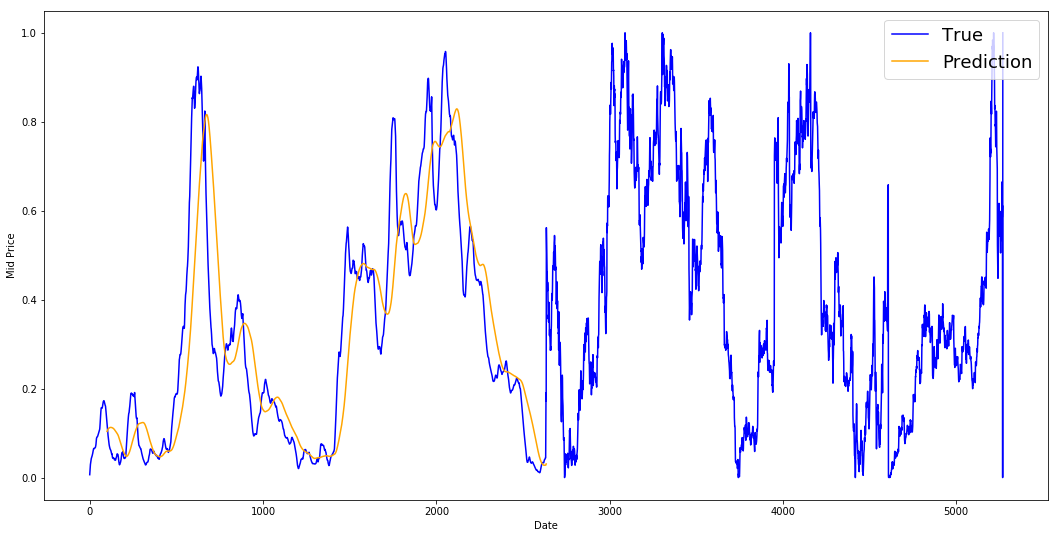

In [203]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Class for generating batches of data of given batch size. Num unroll refers to the number of batch iterations to be created.

In [204]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00643117 0.2799064  0.17687353 0.52544045 0.7520532 ]

	Output: [0.00643117 0.28407788 0.17687353 0.522843   0.756384  ]


Unrolled index 1
	Inputs:  [0.01277136 0.28407788 0.17608158 0.5259047  0.74774224]

	Output: [0.01277136 0.28841573 0.17399259 0.5199349  0.7566072 ]


Unrolled index 2
	Inputs:  [0.01985161 0.28841573 0.1754963  0.5238507  0.7490529 ]

	Output: [0.03241404 0.29898003 0.1754963  0.5238507  0.7535989 ]


Unrolled index 3
	Inputs:  [0.02484976 0.2934178  0.1752995  0.522843   0.7538881 ]

	Output: [0.02484976 0.31193727 0.1749274  0.522843   0.7535989 ]


Unrolled index 4
	Inputs:  [0.02938574 0.29898003 0.1749274  0.5218087  0.756384  ]

	Output: [0.03438659 0.32433566 0.17240767 0.5195736  0.7453823 ]


Setup the hyperparameters for the model

In [214]:
D = 1 # Dimensionality of the data
num_unrollings = 50 # Number of time steps into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph()

In [215]:
train_inputs, train_outputs = [],[]

# unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


Create the LSTM layers and regression layer to optimize

In [216]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [217]:
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Based on inputs optimize the model with adam optimizer and apply the gradient caps.

In [218]:
print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


Setup objects for prediction on test data.

In [ ]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))
  tf.get_variable_scope().reuse_variables()

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Run the model with given epochs while trying to minimize the mse for each iteration.

In [220]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 5 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(mp,mp+1000,50).tolist()
for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized
Average loss at step 1: 2.667358
	Test MSE: 0.11791
	Finished Predictions
Average loss at step 2: 1.294480
	Test MSE: 0.04389
	Finished Predictions
Average loss at step 3: 0.382804
	Test MSE: 0.05109
	Finished Predictions
Average loss at step 4: 0.603237
	Test MSE: 0.02308
	Finished Predictions
Average loss at step 5: 0.266810
	Test MSE: 0.02715
	Finished Predictions
Average loss at step 6: 0.235864
	Test MSE: 0.01480
	Finished Predictions
Average loss at step 7: 0.204031
	Test MSE: 0.01710
	Finished Predictions
Average loss at step 8: 0.173870
	Test MSE: 0.02066
	Finished Predictions
Average loss at step 9: 0.133624
	Test MSE: 0.01692
	Finished Predictions
Average loss at step 10: 0.109354
	Test MSE: 0.01871
	Finished Predictions
Average loss at step 11: 0.115804
	Test MSE: 0.01866
	Finished Predictions
Average loss at step 12: 0.125808
	Decreasing learning rate by 0.5
	Test MSE: 0.01721
	Finished Predictions
Average loss at step 13: 0.110046
	Test MSE: 0.01659
	Finished P

Plot the prediction for each batch with darker alpha values as the most recent predictions.

IndexError: list index out of range

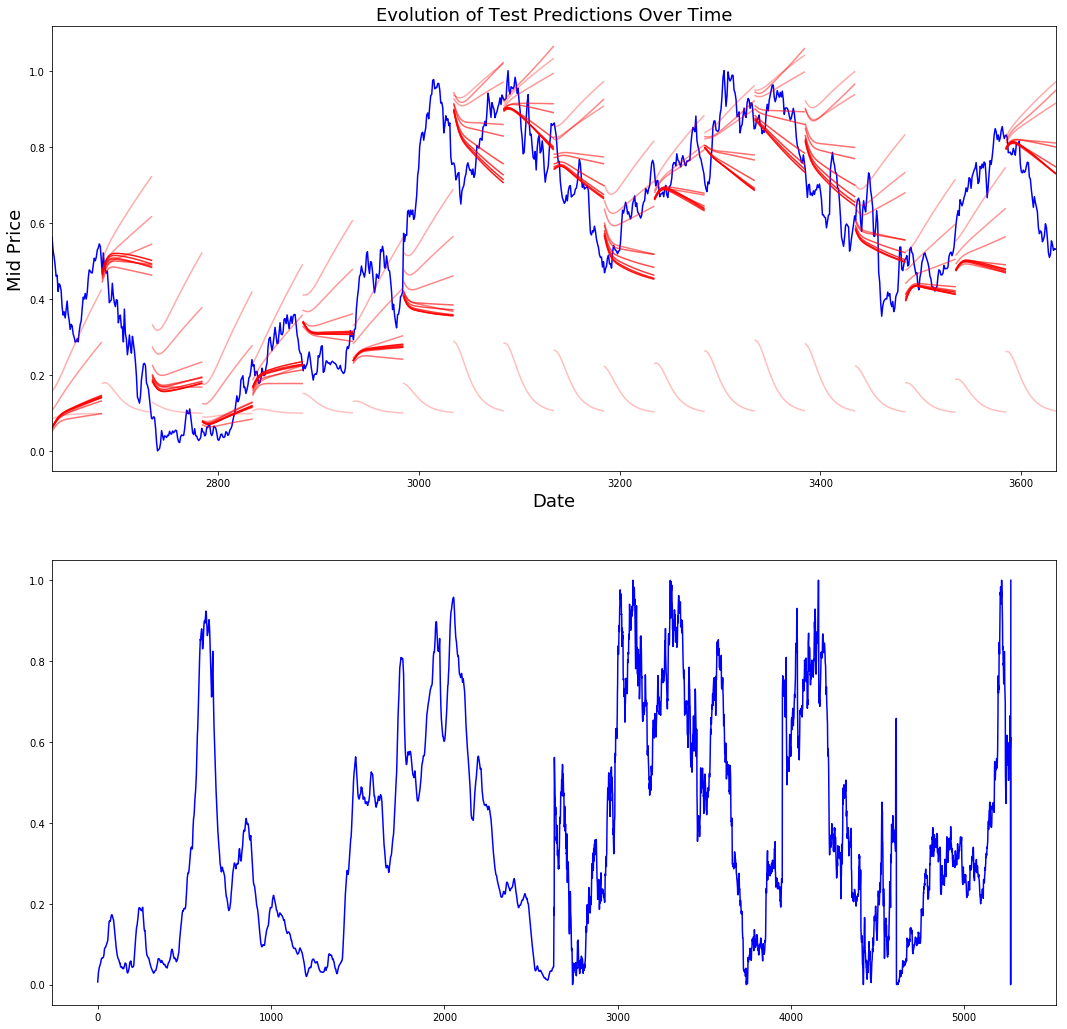

In [221]:
best_prediction_epoch = 488 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(mp,mp + 1000)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(mp,mp + 1000)
plt.show(mp,mp + 1000)